Imports


In [ ]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import os
import zipfile
from pathlib import Path
import requests
import os
from typing import List
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:
!pip install torchinfo

In [ ]:
def plot_predictions(
    train_data, train_labels, val_data, val_labels, predictions=None
):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(val_data, val_labels, c="g", s=4, label="Validation data")

    if predictions is not None:
        plt.scatter(val_data, predictions, c="r", s=4, label="Predictions")
    plt.legend(prop={"size": 14})

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def print_train_time(start, end, device=None):
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

def plot_loss_curves(results):
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Train Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image / 255.0
    if transform:
        target_image = transform(target_image)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)
        target_image_pred = model(target_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
class_names = ['COVID19','NORMAL','PNEUMONIA']
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
from torchinfo import summary
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
train_dir = '/content/drive/MyDrive/covid/Data/train'
test_dir = '/content/drive/MyDrive/covid/Data/test'

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS,
    num_samples_train: int = 1000,
    num_samples_val: int = 500,
    num_samples_test: int = 500
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  train_data, _ = random_split(train_data, [num_samples_train, len(train_data) - num_samples_train])
  val_data, _ = random_split(test_data, [num_samples_val, len(test_data) - num_samples_val])
  test_data, _ = random_split(test_data, [num_samples_test, len(test_data) - num_samples_test])


  train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
  val_dataloader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
  test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

  return train_dataloader, val_dataloader, test_dataloader, class_names

In [ ]:
train_dataloader_pretrained, val_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=16)

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()

    val_loss, val_acc = 0, 0

    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            val_pred_logits = model(X)

            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
    }

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        val_loss, val_acc = val_step(model=model,
          dataloader=val_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results

In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      val_dataloader=val_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1010 | train_acc: 0.9688 | val_loss: 0.1703 | val_acc: 0.8750
Epoch: 2 | train_loss: 0.0864 | train_acc: 0.9707 | val_loss: 0.1129 | val_acc: 0.9643
Epoch: 3 | train_loss: 0.0781 | train_acc: 0.9863 | val_loss: 0.1199 | val_acc: 0.9554
Epoch: 4 | train_loss: 0.0732 | train_acc: 0.9844 | val_loss: 0.1431 | val_acc: 0.9018
Epoch: 5 | train_loss: 0.0745 | train_acc: 0.9766 | val_loss: 0.1669 | val_acc: 0.9018
Epoch: 6 | train_loss: 0.0626 | train_acc: 0.9863 | val_loss: 0.1120 | val_acc: 0.9643
Epoch: 7 | train_loss: 0.0570 | train_acc: 0.9824 | val_loss: 0.1027 | val_acc: 0.9643
Epoch: 8 | train_loss: 0.0506 | train_acc: 0.9941 | val_loss: 0.1052 | val_acc: 0.9554
Epoch: 9 | train_loss: 0.0500 | train_acc: 0.9941 | val_loss: 0.0937 | val_acc: 0.9732
Epoch: 10 | train_loss: 0.0441 | train_acc: 0.9961 | val_loss: 0.0860 | val_acc: 0.9732


In [ ]:
len(test_dataloader_pretrained)

32

In [ ]:
torch.save(pretrained_vit.state_dict(), "/content/drive/MyDrive/Saved/vit.pth")
torch.save(pretrained_vit_results, "/content/drive/MyDrive/Saved/vit_res.pth")

In [ ]:
pretrained_vit.load_state_dict(torch.load("/content/drive/MyDrive/Saved/vit.pth"))
pretrained_vit.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
your_model=pretrained_vit
test_dataloader=test_dataloader_pretrained
your_model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = your_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_fn(torch.tensor(all_labels), torch.tensor(all_predictions))
print(f"Testing Accuracy: {test_accuracy:.2f}%")

print("Classification Report:")
print(classification_report(all_labels, all_predictions))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_predictions))

Testing Accuracy: 94.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        42
           1       0.92      0.87      0.90       126
           2       0.94      0.98      0.96       332

    accuracy                           0.94       500
   macro avg       0.95      0.90      0.92       500
weighted avg       0.94      0.94      0.94       500

Confusion Matrix:
[[ 35   2   5]
 [  0 110  16]
 [  0   7 325]]


In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

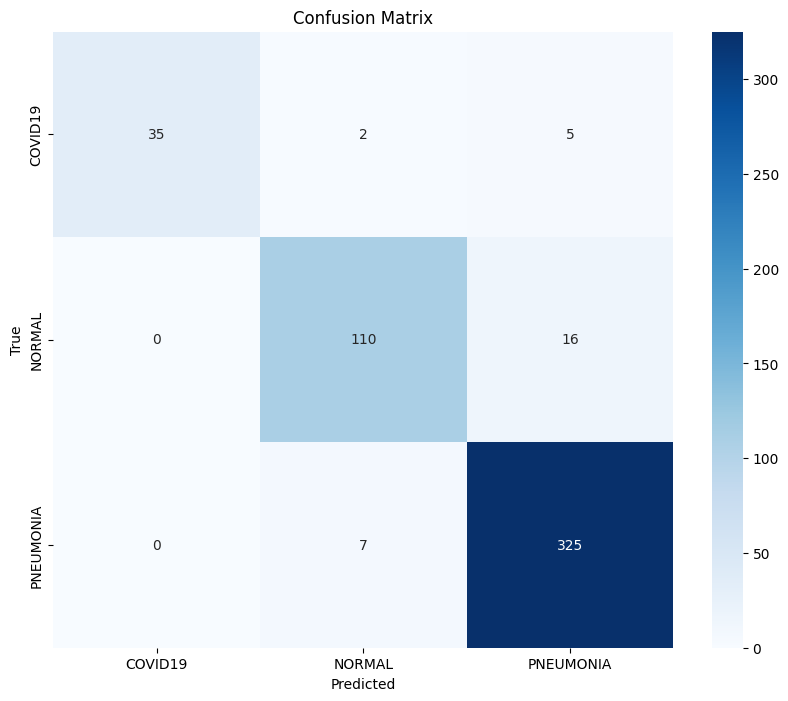

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(all_labels, all_predictions), annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from torchvision import transforms
from itertools import combinations

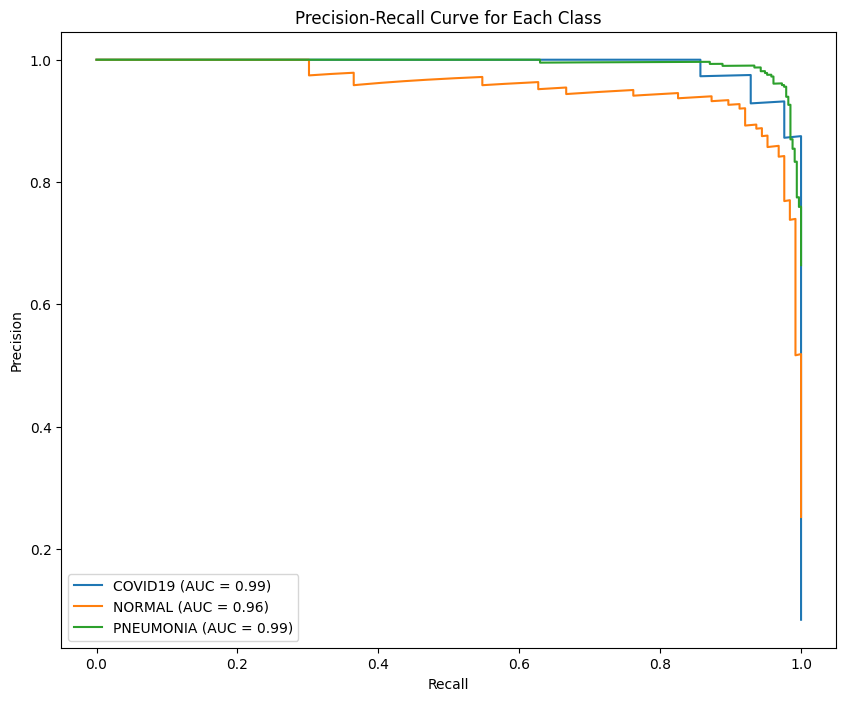

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

y_true = []
y_scores = []
num_classes=3

with torch.no_grad():
    for inputs, labels in test_dataloader_pretrained:
        outputs = pretrained_vit(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        y_true.extend(labels.numpy())
        y_scores.extend(probabilities.numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

precision = dict()
recall = dict()
average_precision = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_scores[:, i])
    average_precision[i] = auc(recall[i], precision[i])
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AUC = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()


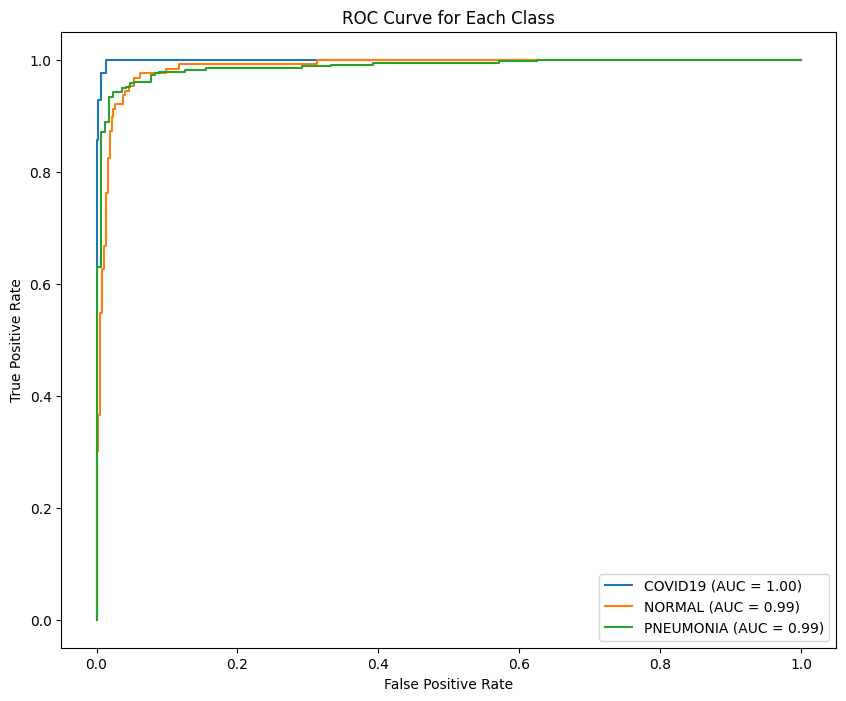

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = 3

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.show()

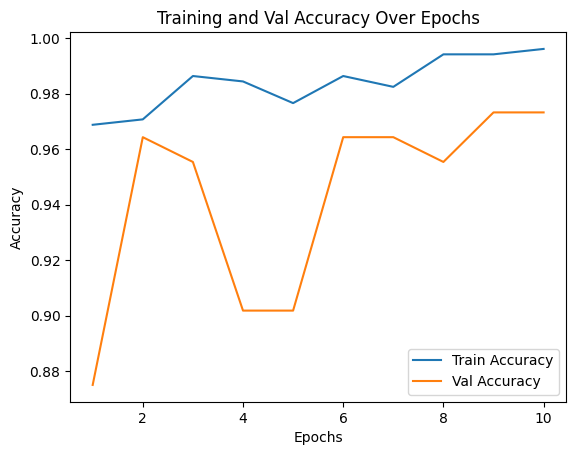

In [ ]:
epochs = list(range(1, len(pretrained_vit_results['val_acc']) + 1))
plt.plot(epochs, pretrained_vit_results['train_acc'], label='Train Accuracy')
plt.plot(epochs, pretrained_vit_results['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy Over Epochs')
plt.legend()
plt.show()


In [ ]:
accuracy = pretrained_vit_results["train_acc"]
val_accuracy = pretrained_vit_results["val_acc"]

In [ ]:
print(val_accuracy)

[0.875, 0.9642857142857143, 0.9553571428571429, 0.9017857142857143, 0.9017857142857143, 0.9642857142857143, 0.9642857142857143, 0.9553571428571429, 0.9732142857142857, 0.9732142857142857]


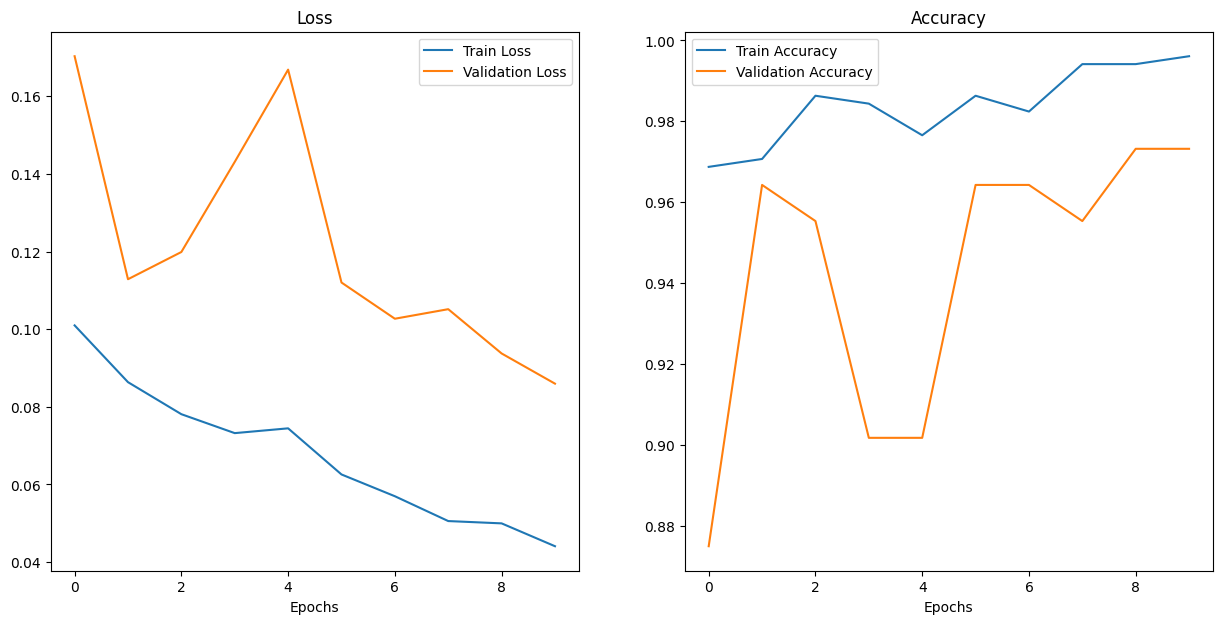

In [ ]:
plot_loss_curves(pretrained_vit_results)

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("/content/drive/MyDrive/covid/Data/test/COVID19/COVID19(511).jpg")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img = transform(img)
img_resized_pil = transforms.ToPILImage()(img)
img_resized_pil.save("/content/drive/MyDrive/covid/Saved resized/resized_image.jpg")



In [ ]:
from PIL import Image

img_path = "/content/drive/MyDrive/covid/Saved resized/resized_image.jpg"
img = Image.open(img_path)

img_rgb = img.convert("RGB")

img_rgb.save("/content/drive/MyDrive/covid/Saved resized/resized_image2.jpg")


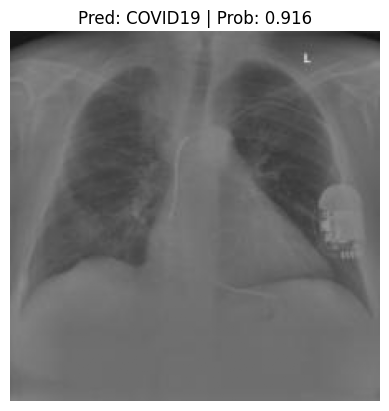

In [ ]:
import requests

custom_image_path = "/content/drive/MyDrive/covid/Saved resized/resized_image2.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)